In [1]:
# Import packages
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import six
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

In [2]:
# This is a function to display data frames as a table
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [3]:
# This is code for plotting confusion matrices
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
#This is a function for plotting most important features
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['green' if c < 0 else 'red' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [5]:
# Plot results
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

In [6]:
# Load data
df = pd.read_csv('data/train_E6oV3lV.csv')

In [7]:
print(df.head())
print(len(df), " tweets")

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
31962  tweets


In [ ]:
print(df[df['label'] == 0].head())

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


In [ ]:
print(df[df['label'] == 1].head(10))

      id  label                                              tweet
13    14      1  @user #cnn calls #michigan middle school 'buil...
14    15      1  no comment!  in #australia   #opkillingbay #se...
17    18      1                             retweet if you agree! 
23    24      1    @user @user lumpy says i am a . prove it lumpy.
34    35      1  it's unbelievable that in the 21st century we'...
56    57      1            @user lets fight against  #love #peace 
68    69      1  Ã°ÂŸÂ˜Â©the white establishment can't have blk...
77    78      1  @user hey, white people: you can call people '...
82    83      1  how the #altright uses  &amp; insecurity to lu...
111  112      1  @user i'm not interested in a #linguistics tha...


In [ ]:
df.shape

(31962, 3)

In [ ]:
# Create a function to clean the tweets
def clean_data(df):
    # Remove punctuation
    df['tweet'] = df['tweet'].str.replace('[^\w\s]','')
    # Remove numbers
    df['tweet'] = df['tweet'].str.replace('[^a-zA-Z#\s]','')
    # Remove capitalization
    df['tweet'] = df['tweet'].str.lower()   
    # Remove user 
    df['tweet'] = df['tweet'].str.replace('user','')
    # Return df
    return df
#stop word removal
#from nltk.corpus import stopwords
#stop = stopwords.words('english')
#df['tweet'].apply(lambda x: [item for item in x if item not in stop])


In [ ]:
clean_df = clean_data(df)

In [ ]:
clean_df.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for lyft credit i cant use cause they...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [ ]:
# Create normalized vectorizer
my_vectorizer = TfidfVectorizer(
    #token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',
    input='contents',
    analyzer = 'word',
    stop_words='english',
    lowercase = True
)

In [ ]:
transformed_vectors = my_vectorizer.fit_transform(clean_df.tweet)
column_names = my_vectorizer.get_feature_names()
my_dtm = pd.DataFrame(transformed_vectors.toarray(),columns = column_names)

label_list = clean_df.label.values
my_dtm['Label'] = label_list
clean_normalized_df = pd.DataFrame()
clean_normalized_df = clean_normalized_df.append(my_dtm)

In [ ]:
def my_nb_results(df):
    #Split the data
    print("preparing data")
    train_df, test_df = train_test_split(df, test_size=0.4)
    
    #Get test labels
    test_labels = test_df['Label']

    # Remove test labels
    test_df = test_df.drop(['Label'], axis=1)

    # Create svm modeler
    print("creating NB")
    my_nb = MultinomialNB()

    # Separate labels from train data
    train_no_labels = train_df.drop(['Label'], axis=1)
    train_labels = train_df['Label']

    # Fit the svm model
    print("training model")
    my_nb.fit(train_no_labels, train_labels)
    predictions = my_nb.predict(test_df)
    print(my_nb.score(test_df, test_labels))

    # Get the confusion matrix
    print("generating confusion matrix")
    cnf_matrix = confusion_matrix(test_labels, predictions)
    print("The confusion matrix is:")
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, ['0','1'])
    
    #for row_index in (predictions, test_labels):
        #if predictions.isin(test_labels):
            #print('Row', row_index, 'has been classified as ', predictions, 'and should be ', test_labels)
    

preparing data
creating NB
training model
0.9411028549080954
generating confusion matrix
The confusion matrix is:
[[11943     0]
 [  753    89]]


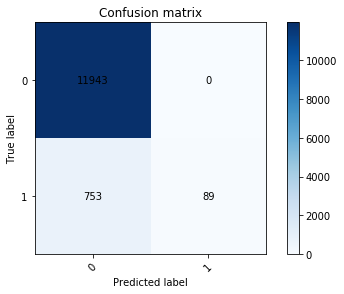

In [ ]:
my_nb_results(clean_normalized_df)

In [ ]:
def my_svm_results(df):
    # Split the data
    print("preparing data")
    train_df, test_df = train_test_split(df, test_size=0.4)
    
    # Get test labels
    test_labels = test_df['Label']

    # Remove test labels
    test_df = test_df.drop(['Label'], axis=1)

    # Create svm modeler
    print("creating SVM")
    my_svm = LinearSVC(C=10)

    # Separate labels from train data
    train_no_labels = train_df.drop(['Label'], axis=1)
    train_labels = train_df['Label']

    # Fit the svm model
    print("training model")
    my_svm.fit(train_no_labels, train_labels)
    predictions = my_svm.predict(test_df)
    print(my_svm.score(test_df, test_labels))

    # Get the confusion matrix
    print("generating confusion matrix")
    cnf_matrix = confusion_matrix(test_labels, predictions)
    print("The confusion matrix is:")
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, ['0','1'])
    
    # Plot most influential features
    plot_coefficients(my_svm, column_names)
    
    # Compute the ten fold cross validation
    print("The 10-fold cross validation is")
    print(cross_val_score(my_svm, train_no_labels, train_labels, cv = 10))
    cv = cross_val_score(my_svm, train_no_labels, train_labels, cv = 10)
    cv_df = pd.DataFrame()
    cv_df['Cross Val Scores'] = cv
    cv_df = cv_df.round(4)
    render_mpl_table(cv_df)
    
    # Generate a word cloud of train data
    #Get column names
    print("generating word cloud")
    words = list(train_no_labels.columns)
    # iterate over columns to sum word counts
    counts = []
    for i, idx in enumerate(train_no_labels.columns, 1):
        total = train_no_labels.iloc[:,:1].all(axis=1).sum()
        counts.append(total)
    
    cloud_df = pd.DataFrame({
        "words": words,
        "counts": counts,
    })
    
    # Create dictionary to store word counts
    d = {}
    # Iterate over dictionary to get word counts
    for a, x in cloud_df.values:
        d[a] = x
    # Get wordcloud object
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies = d)
    plt.figure()
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.show()
    

preparing data
creating SVM
training model
0.95831052014079
generating confusion matrix
The confusion matrix is:
[[11746   132]
 [  401   506]]


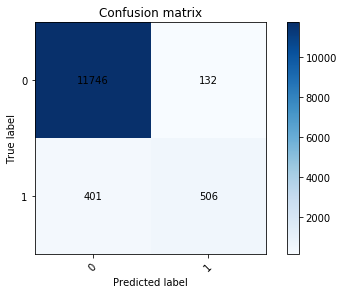

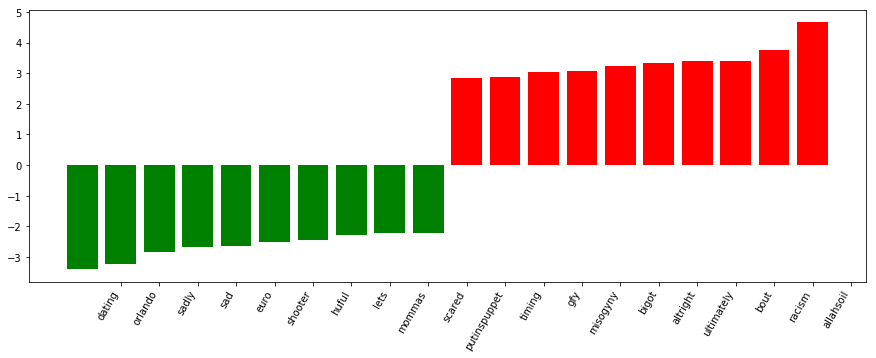

The 10-fold cross validation is


In [ ]:
my_svm_results(clean_normalized_df)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Random Forest
def my_rf_results(df):
    # Split the data
    print("preparing data")
    train_df, test_df = train_test_split(df, test_size=0.4)
    
    # Get test labels
    test_labels = test_df['Label']

    # Remove test labels
    test_df = test_df.drop(['Label'], axis=1)

    # Create RF modeler
    print("creating Random Forest")
    my_rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

    # Separate labels from train data
    train_no_labels = train_df.drop(['Label'], axis=1)
    train_labels = train_df['Label']

    # Fit the random forest model
    print("training model")
    my_rf.fit(train_no_labels, train_labels)
    predictions = my_rf.predict(test_df)
    print(my_rf.score(test_df, test_labels))

    # Get the confusion matrix
    print("generating confusion matrix")
    cnf_matrix = confusion_matrix(test_labels, predictions)
    print("The confusion matrix is:")
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, ['0','1'])


In [ ]:
my_rf_results(clean_normalized_df)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras

In [ ]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import tensorflow as tf


def tf_no_warning():
    """
    Make Tensorflow less verbose
    """
    try:

        tf.logging.set_verbosity(tf.logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

    except ImportError:
        pass

In [ ]:
tf_no_warning()


In [ ]:
#Keras NN Fit
def my_keras_results(df):
    # Split the data
    print("preparing data")
    train_df, test_df = train_test_split(df, test_size=0.4)
    
    # Get test labels
    test_labels = test_df['Label']

    # Remove test labels
    test_df = test_df.drop(['Label'], axis=1)

    # Create Keras NN modeler
    print("creating Keras model")
    
   #Keras Model
    model = Sequential()
    model.add(Dense(200, input_dim=39410, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # Separate labels from train data
    train_no_labels = train_df.drop(['Label'], axis=1)
    train_labels = train_df['Label']

    # Fit the Keras model
    print("training model")
    history = model.fit(train_no_labels, train_labels, batch_size=32, epochs=50)
    predictions = model.predict(test_df)
    plot_train_curve(history)
    


In [ ]:
my_keras_results(clean_normalized_df)